# **Bioinformatics Project - Computational Drug Discovery [Part 2] Exploratory Data Analysis**

Chanin Nantasenamat

[*'Data Professor' YouTube channel*](http://youtube.com/dataprofessor)

In this Jupyter notebook, we will be building a real-life **data science project** that you can include in your **data science portfolio**. Particularly, we will be building a machine learning model using the ChEMBL bioactivity data.

In **Part 2**, we will be performing Descriptor Calculation and Exploratory Data Analysis.

---

## **Install conda and rdkit**

In [12]:
#! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
!conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

zsh:1: command not found: conda


## **Load bioactivity data**

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('Data/bioactivity_preprocessed_data.csv')
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,0
0,CHEMBL488,CCC1(c2ccc(N)cc2)CCC(=O)NC1=O,34000.0,inactive
1,CHEMBL93828,O=C1c2cccc(O)c2CCC1Cc1ccncc1,2000.0,intermediate
2,CHEMBL90427,COc1cccc2c1CCC(Cc1ccncc1)C2=O,8000.0,intermediate
3,CHEMBL100749,Cn1nnc2ccc(C(c3ccc(Cl)cc3)n3cncn3)cc21,3.0,active
4,CHEMBL488,CCC1(c2ccc(N)cc2)CCC(=O)NC1=O,6200.0,intermediate


## **Calculate Lipinski descriptors**
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the **druglikeness** of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile. Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the **Rule-of-Five** or **Lipinski's Rule**.

The Lipinski's Rule stated the following:
* Molecular weight < 500 Dalton
* Octanol-water partition coefficient (LogP) < 5
* Hydrogen bond donors < 5
* Hydrogen bond acceptors < 10 

### **Import libraries**

In [3]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

### **Calculate descriptors**

In [4]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [5]:
df_lipinski = lipinski(df.canonical_smiles)

### **Combine DataFrames**

Let's take a look at the 2 DataFrames that will be combined.

In [6]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,232.283,1.3532,2.0,3.0
1,253.301,2.7750,1.0,3.0
2,267.328,3.0780,0.0,3.0
3,324.775,2.8509,0.0,6.0
4,232.283,1.3532,2.0,3.0
5,251.329,3.5336,0.0,2.0
6,235.286,3.2941,0.0,2.0
7,224.263,2.6222,1.0,2.0
8,224.263,2.6222,1.0,2.0
9,316.441,4.0599,0.0,3.0


In [8]:
df

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.0,intermediate
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.0,intermediate
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.0,inactive
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.0,inactive
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.0,intermediate
...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,10600.0,inactive
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,10100.0,inactive
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,11500.0,inactive
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,10700.0,inactive


Now, let's combine the 2 DataFrame

In [7]:
df_combined = pd.concat([df,df_lipinski], axis=1)

In [9]:
df_combined.shape

(11, 8)

### **Convert IC50 to pIC50**
To allow **IC50** data to be more uniformly distributed, we will convert **IC50** to the negative logarithmic scale which is essentially **-log10(IC50)**.

This custom function pIC50() will accept a DataFrame as input and will:
* Take the IC50 values from the ``standard_value`` column and converts it from nM to M by multiplying the value by 10$^{-9}$
* Take the molar value and apply -log10
* Delete the ``standard_value`` column and create a new ``pIC50`` column

In [10]:
# https://github.com/chaninlab/estrogen-receptor-alpha-qsar/blob/master/02_ER_alpha_RO5.ipynb

import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

Point to note: Values greater than 100,000,000 will be fixed at 100,000,000 otherwise the negative logarithmic value will become negative.

In [11]:
df_combined.standard_value.describe()

count       11.000000
mean      5093.454545
std       9992.655116
min          3.000000
25%        255.000000
50%        280.000000
75%       5400.000000
max      34000.000000
Name: standard_value, dtype: float64

In [12]:
-np.log10( (10**-9)* 100000000 )

1.0

In [13]:
-np.log10( (10**-9)* 10000000000 )

-1.0

In [14]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

We will first apply the norm_value() function so that the values in the standard_value column is normalized.

In [15]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,0,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL488,CCC1(c2ccc(N)cc2)CCC(=O)NC1=O,inactive,232.283,1.3532,2.0,3.0,34000.0
1,CHEMBL93828,O=C1c2cccc(O)c2CCC1Cc1ccncc1,intermediate,253.301,2.7750,1.0,3.0,2000.0
2,CHEMBL90427,COc1cccc2c1CCC(Cc1ccncc1)C2=O,intermediate,267.328,3.0780,0.0,3.0,8000.0
3,CHEMBL100749,Cn1nnc2ccc(C(c3ccc(Cl)cc3)n3cncn3)cc21,active,324.775,2.8509,0.0,6.0,3.0
4,CHEMBL488,CCC1(c2ccc(N)cc2)CCC(=O)NC1=O,intermediate,232.283,1.3532,2.0,3.0,6200.0
5,CHEMBL294361,COc1ccc2c(c1)C1C(CC2)C1c1ccncc1,active,251.329,3.5336,0.0,2.0,265.0
6,CHEMBL90585,O=C1/C(=C/c2ccncc2)CCc2ccccc21,intermediate,235.286,3.2941,0.0,2.0,4600.0
7,CHEMBL168434,O=C1/C(=C/c2c[nH]cn2)CCc2ccccc21,active,224.263,2.6222,1.0,2.0,170.0
8,CHEMBL169251,O=C1/C(=C\c2c[nH]cn2)CCc2ccccc21,active,224.263,2.6222,1.0,2.0,260.0
9,CHEMBL3753401,C[C@@H]1OC(=O)C[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4...,active,316.441,4.0599,0.0,3.0,280.0


In [16]:
df_norm.standard_value_norm.describe()

count       11.000000
mean      5093.454545
std       9992.655116
min          3.000000
25%        255.000000
50%        280.000000
75%       5400.000000
max      34000.000000
Name: standard_value_norm, dtype: float64

In [17]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,0,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL488,CCC1(c2ccc(N)cc2)CCC(=O)NC1=O,inactive,232.283,1.3532,2.0,3.0,4.468521
1,CHEMBL93828,O=C1c2cccc(O)c2CCC1Cc1ccncc1,intermediate,253.301,2.7750,1.0,3.0,5.698970
2,CHEMBL90427,COc1cccc2c1CCC(Cc1ccncc1)C2=O,intermediate,267.328,3.0780,0.0,3.0,5.096910
3,CHEMBL100749,Cn1nnc2ccc(C(c3ccc(Cl)cc3)n3cncn3)cc21,active,324.775,2.8509,0.0,6.0,8.522879
4,CHEMBL488,CCC1(c2ccc(N)cc2)CCC(=O)NC1=O,intermediate,232.283,1.3532,2.0,3.0,5.207608
5,CHEMBL294361,COc1ccc2c(c1)C1C(CC2)C1c1ccncc1,active,251.329,3.5336,0.0,2.0,6.576754
6,CHEMBL90585,O=C1/C(=C/c2ccncc2)CCc2ccccc21,intermediate,235.286,3.2941,0.0,2.0,5.337242
7,CHEMBL168434,O=C1/C(=C/c2c[nH]cn2)CCc2ccccc21,active,224.263,2.6222,1.0,2.0,6.769551
8,CHEMBL169251,O=C1/C(=C\c2c[nH]cn2)CCc2ccccc21,active,224.263,2.6222,1.0,2.0,6.585027
9,CHEMBL3753401,C[C@@H]1OC(=O)C[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4...,active,316.441,4.0599,0.0,3.0,6.552842


In [18]:
df_final.pIC50.describe()

count    11.000000
mean      6.128942
std       1.115168
min       4.468521
25%       5.272425
50%       6.552842
75%       6.593543
max       8.522879
Name: pIC50, dtype: float64

In [20]:
df_final.rename(columns = {"0":"bioactivity_class"}, inplace = True)

### **Removing the 'intermediate' bioactivity class**
Here, we will be removing the ``intermediate`` class from our data set.

In [21]:
df_2class = df_final[df_final.bioactivity_class != 'intermediate']
df_2class

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL488,CCC1(c2ccc(N)cc2)CCC(=O)NC1=O,inactive,232.283,1.3532,2.0,3.0,4.468521
3,CHEMBL100749,Cn1nnc2ccc(C(c3ccc(Cl)cc3)n3cncn3)cc21,active,324.775,2.8509,0.0,6.0,8.522879
5,CHEMBL294361,COc1ccc2c(c1)C1C(CC2)C1c1ccncc1,active,251.329,3.5336,0.0,2.0,6.576754
7,CHEMBL168434,O=C1/C(=C/c2c[nH]cn2)CCc2ccccc21,active,224.263,2.6222,1.0,2.0,6.769551
8,CHEMBL169251,O=C1/C(=C\c2c[nH]cn2)CCc2ccccc21,active,224.263,2.6222,1.0,2.0,6.585027
9,CHEMBL3753401,C[C@@H]1OC(=O)C[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4...,active,316.441,4.0599,0.0,3.0,6.552842
10,CHEMBL3754484,C[C@@H]1OC(=O)C[C@H]2[C@@H]3C=C[C@H]4C[C@@H](O...,active,318.457,3.7076,1.0,3.0,6.602060


---

## **Exploratory Data Analysis (Chemical Space Analysis) via Lipinski descriptors**

### **Import library**

In [23]:
!pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
     |████████████████████████████████| 28.8 MB 2.2 MB/s eta 0:00:011
     |████████████████████████████████| 8.5 MB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 10.4 MB/s eta 0:00:01
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


In [24]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

### **Frequency plot of the 2 bioactivity classes**

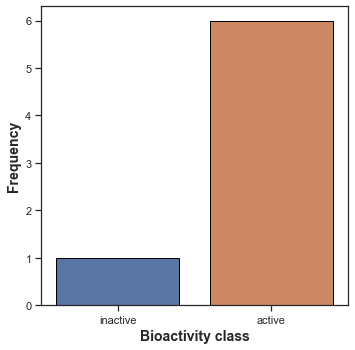

In [25]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

### **Scatter plot of MW versus LogP**

It can be seen that the 2 bioactivity classes are spanning similar chemical spaces as evident by the scatter plot of MW vs LogP.

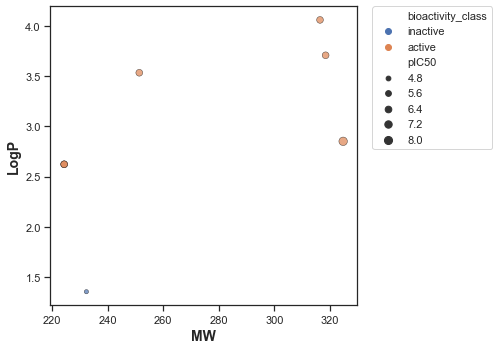

In [26]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

### **Box plots**

#### **pIC50 value**

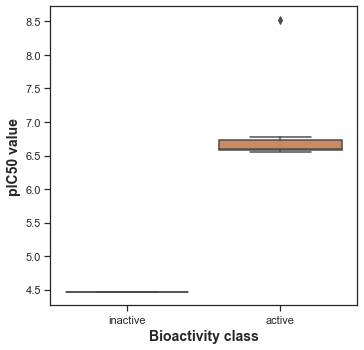

In [27]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [28]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df.bioactivity_class == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df.bioactivity_class == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

In [29]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,0.10565,0.05,Same distribution (fail to reject H0)


#### **MW**

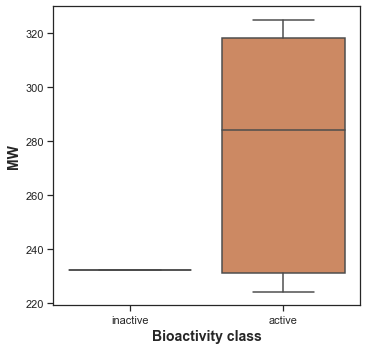

In [30]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [31]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,2.0,0.400419,0.05,Same distribution (fail to reject H0)


#### **LogP**

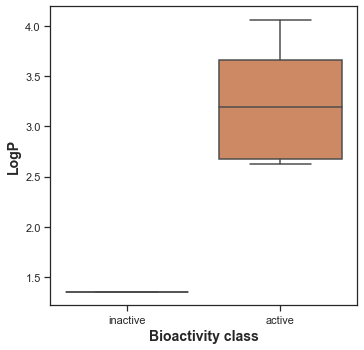

In [32]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [33]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,0.0,0.103598,0.05,Same distribution (fail to reject H0)


#### **NumHDonors**

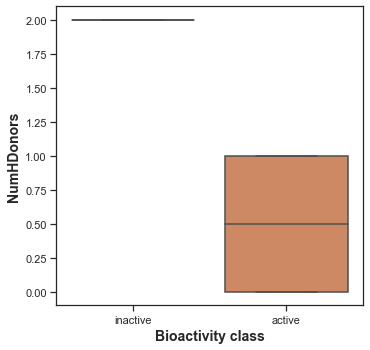

In [34]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**Statistical analysis | Mann-Whitney U Test**

In [35]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,0.0,0.088483,0.05,Same distribution (fail to reject H0)


#### **NumHAcceptors**

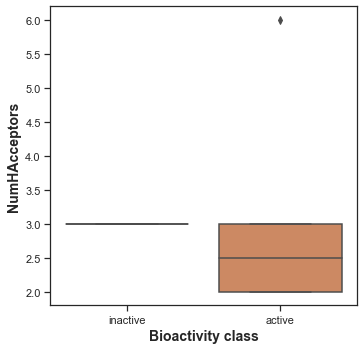

In [36]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'bioactivity_class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [37]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,2.0,0.393568,0.05,Same distribution (fail to reject H0)


#### **Interpretation of Statistical Results**

##### **Box Plots**

###### **pIC50 values**

Taking a look at pIC50 values, the **actives** and **inactives** displayed ***statistically significant difference***, which is to be expected since threshold values (``IC50 < 1,000 nM = Actives while IC50 > 10,000 nM = Inactives``, corresponding to ``pIC50 > 6 = Actives and pIC50 < 5 = Inactives``) were used to define actives and inactives.

###### **Lipinski's descriptors**

Of the 4 Lipinski's descriptors (MW, LogP, NumHDonors and NumHAcceptors), only LogP exhibited ***no difference*** between the **actives** and **inactives** while the other 3 descriptors (MW, NumHDonors and NumHAcceptors) shows ***statistically significant difference*** between **actives** and **inactives**.

## **Zip files**

In [38]:
! zip -r results.zip . -i *.csv *.pdf

  adding: mannwhitneyu_NumHAcceptors.csv (deflated 9%)
  adding: mannwhitneyu_NumHDonors.csv (deflated 10%)
  adding: mannwhitneyu_MW.csv (deflated 8%)
  adding: plot_bioactivity_class.pdf (deflated 38%)
  adding: plot_LogP.pdf (deflated 38%)
  adding: plot_MW.pdf (deflated 38%)
  adding: plot_NumHDonors.pdf (deflated 39%)
  adding: plot_NumHAcceptors.pdf (deflated 37%)
  adding: plot_ic50.pdf (deflated 37%)
  adding: mannwhitneyu_pIC50.csv (deflated 10%)
  adding: plot_MW_vs_LogP.pdf (deflated 32%)
  adding: mannwhitneyu_LogP.csv (deflated 8%)
